## 1. Environment Setup and Libraries

We start by importing the core libraries. pandas and numpy handle the data, sklearn provides the machine learning tools, and matplotlib/seaborn are used for visualizing the regression results.

In [ ]:
!pip install -q gdown

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Data Loading

### 2.1. Downloading Dataset

In [ ]:
!gdown 1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9 -O regresi-dataset.csv

Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=29237833-c121-4ae9-ac5d-47a63b50a9b5
To: /content/regresi-dataset.csv
100% 443M/443M [00:09<00:00, 49.2MB/s]


### 2.2. Loading to Dataframe & Column Naming

Since your dataset does not contain headers (the first row is actual data), we load it with header=None. We then programmatically name the first column as the target_year and the rest as feature_1, feature_2, etc.

In [ ]:
# Define your file path
FILE_PATH = 'regresi-dataset.csv'

# Load the dataset
df = pd.read_csv(FILE_PATH, header=None)

# Naming: First column is the release year, subsequent columns are features
column_names = ['target_year'] + [f'feature_{i}' for i in range(1, df.shape[1])]
df.columns = column_names

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded with 515345 rows and 91 columns.


## 3. Data Cleaning

Regression models are highly sensitive to outliers. We check for missing values and use the Interquartile Range (IQR) method to remove extreme values in the target variable (years) that might distort the linear relationship.

Total Missing Values: 0
Outliers removed: 29703 rows.


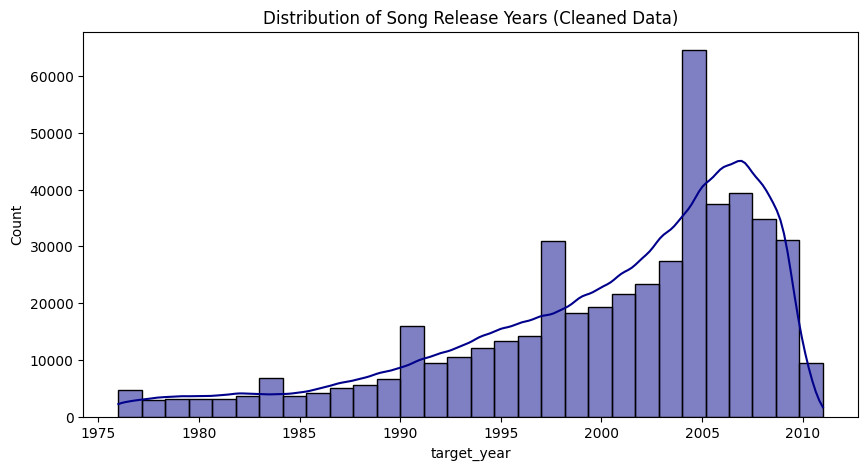

In [ ]:
# Check for Missing Values
print(f"Total Missing Values: {df.isnull().sum().sum()}")

# Outlier Removal for 'target_year' using IQR
Q1 = df['target_year'].quantile(0.25)
Q3 = df['target_year'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data
df_cleaned = df[(df['target_year'] >= lower_bound) & (df['target_year'] <= upper_bound)].copy()

print(f"Outliers removed: {len(df) - len(df_cleaned)} rows.")

# Visualize the distribution of the target
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['target_year'], kde=True, bins=30, color='darkblue')
plt.title('Distribution of Song Release Years (Cleaned Data)')
plt.show()

## 4. Feature Scaling and Splitting

We split the data into a training set (80%) and a testing set (20%). Since audio features often have different scales, we apply Standardization (z-score normalization) to ensure the linear model converges correctly.

In [ ]:
# Split Features (X) and Target (y)
X = df_cleaned.drop(columns=['target_year'])
y = df_cleaned['target_year']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Modelling

### 5.1. Hypertuning Parameter

We use Ridge Regression. Unlike simple linear regression, Ridge includes a hyperparameter $\alpha$ (alpha) that prevents overfitting by penalizing large coefficients. We use GridSearchCV to find the optimal $\alpha$.

In [ ]:
# Initialize Ridge Regression
ridge_reg = Ridge()

# Define the hyperparameter grid for Alpha
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Select the best model
best_model = grid_search.best_estimator_
print(f"Best Hyperparameter (Alpha): {grid_search.best_params_}")

Best Hyperparameter (Alpha): {'alpha': 100.0}


### 5.2. Evaluation Metrics

To assess the model's accuracy, we calculate standard regression metrics.
- Mean Absolute Error (MAE): Average error in years.
- Root Mean Squared Error (RMSE): Standard deviation of the residuals.
- R-squared ($R^2$): Proportion of variance explained by the model.

In [ ]:
# Make Predictions
y_pred = best_model.predict(X_test_scaled)

# Calculate Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

MAE  : 5.1913
MSE  : 45.6233
RMSE : 6.7545
R2 Score: 0.2406


### 5.3. Visualization

This plot compares the Actual Years vs. Predicted Years. A perfect model would show all points aligned along the red dashed diagonal line.

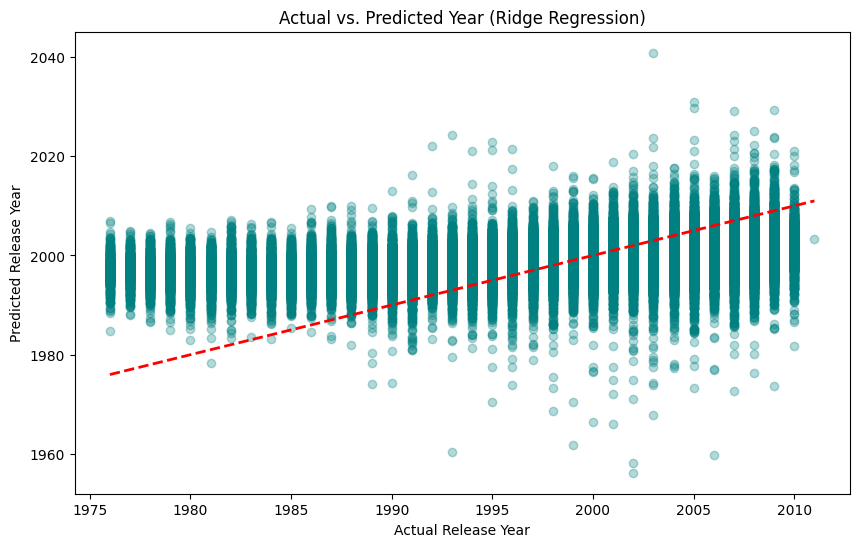

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Release Year')
plt.ylabel('Predicted Release Year')
plt.title('Actual vs. Predicted Year (Ridge Regression)')
plt.show()